In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

from scipy.stats import entropy
import pandas as pd
import numpy as np
import onnxruntime as rt

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
good_model_path = '../model/good_model.onnx'
biased_model_path = '../model/biased_model.onnx'

In [5]:
# functions definition

def calculate_distribution(preds):
    return np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)

def differential_testing_by_sensitive_variable(
        model1_path, 
        model2_path, 
        data_address, 
        sensitive_attributes
):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    X = X.astype(np.float32)

    session1 = rt.InferenceSession(model1_path)
    session2 = rt.InferenceSession(model2_path)
    input_name1 = session1.get_inputs()[0].name
    input_name2 = session2.get_inputs()[0].name

    results = {}

    for attr in sensitive_attributes:
        print(f"Analyzing bias for sensitive attribute: {attr}")
        attr_values = data[attr].unique() 
        kl_divergences = []

        for value in attr_values:

            mask = (data[attr] == value)
            sub_X = X[mask]

            preds_model1 = session1.run(None, {input_name1: sub_X.values.astype(np.float32)})[0]
            preds_model2 = session2.run(None, {input_name2: sub_X.values.astype(np.float32)})[0]

            if preds_model1.ndim > 1 and preds_model2.ndim > 1:
                preds_model1 = np.argmax(preds_model1, axis=1)
                preds_model2 = np.argmax(preds_model2, axis=1)
            
            dist_model1 = calculate_distribution(preds_model1)
            dist_model2 = calculate_distribution(preds_model2)

            kl_div = entropy(dist_model1, qk=dist_model2)
            kl_divergences.append({
                "value": value,
                "kl_divergence": kl_div,
                "dist_model1": dist_model1,
                "dist_model2": dist_model2
            })

        sorted_kl_divs = sorted(kl_divergences, key=lambda x: x['kl_divergence'])
        print(f"Results for {attr}:")
        for div in sorted_kl_divs:
            print(f"  Value: {div['value']}, KL Divergence: {div['kl_divergence']:.4f}")
        results[attr] = kl_divergences

    return results

def visualize_kl_divergences(results):
    
    for attr, kl_data in results.items():
        values = [item['value'] for item in kl_data]
        kl_divergences = [item['kl_divergence'] for item in kl_data]

        plt.figure(figsize=(10, 6))
        plt.bar(values, kl_divergences, color='skyblue', alpha=0.7)
        plt.title(f"KL Divergences for Sensitive Attribute: {attr}")
        plt.xlabel(f"{attr} Values")
        plt.ylabel("KL Divergence")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [6]:
# test

results = differential_testing_by_sensitive_variable(
    good_model_path,
    biased_model_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)

Analyzing bias for sensitive attribute: persoon_leeftijd_bij_onderzoek
Results for persoon_leeftijd_bij_onderzoek:
  Value: 51, KL Divergence: 0.0000
  Value: 47, KL Divergence: 0.0001
  Value: 46, KL Divergence: 0.0002
  Value: 44, KL Divergence: 0.0002
  Value: 49, KL Divergence: 0.0002
  Value: 50, KL Divergence: 0.0003
  Value: 52, KL Divergence: 0.0004
  Value: 48, KL Divergence: 0.0004
  Value: 45, KL Divergence: 0.0005
  Value: 64, KL Divergence: 0.0005
  Value: 63, KL Divergence: 0.0006
  Value: 57, KL Divergence: 0.0006
  Value: 53, KL Divergence: 0.0008
  Value: 56, KL Divergence: 0.0011
  Value: 58, KL Divergence: 0.0015
  Value: 55, KL Divergence: 0.0018
  Value: 61, KL Divergence: 0.0020
  Value: 54, KL Divergence: 0.0021
  Value: 59, KL Divergence: 0.0024
  Value: 62, KL Divergence: 0.0025
  Value: 60, KL Divergence: 0.0029
  Value: 43, KL Divergence: 0.0372
  Value: 42, KL Divergence: 0.0388
  Value: 41, KL Divergence: 0.0393
  Value: 36, KL Divergence: 0.0414
  Value: 3

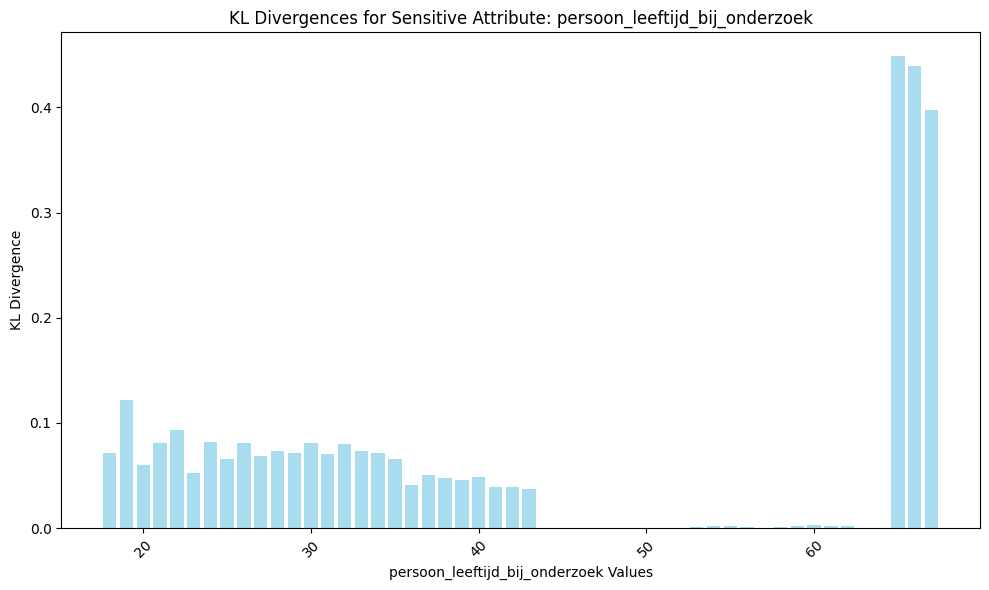

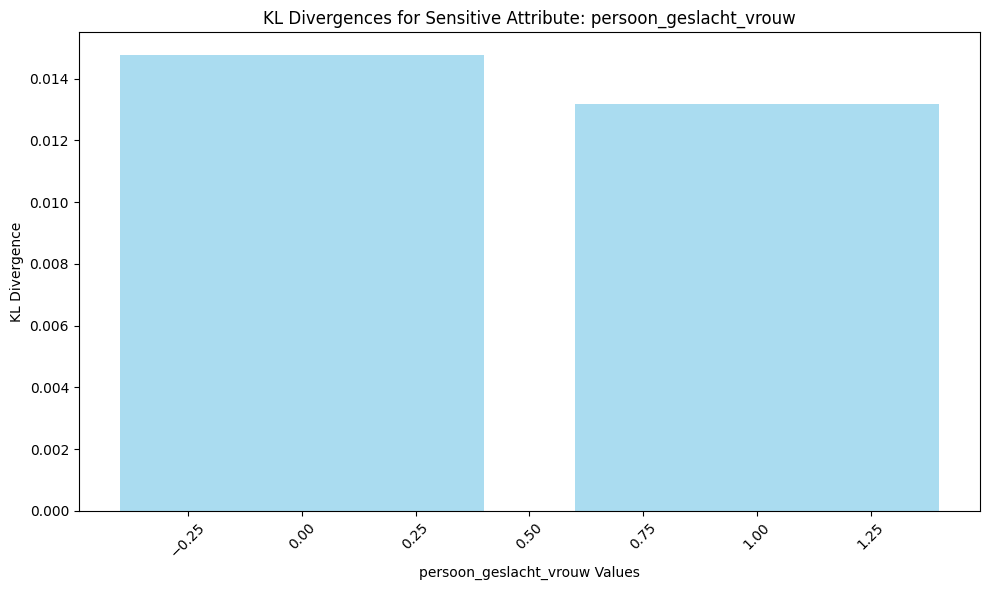

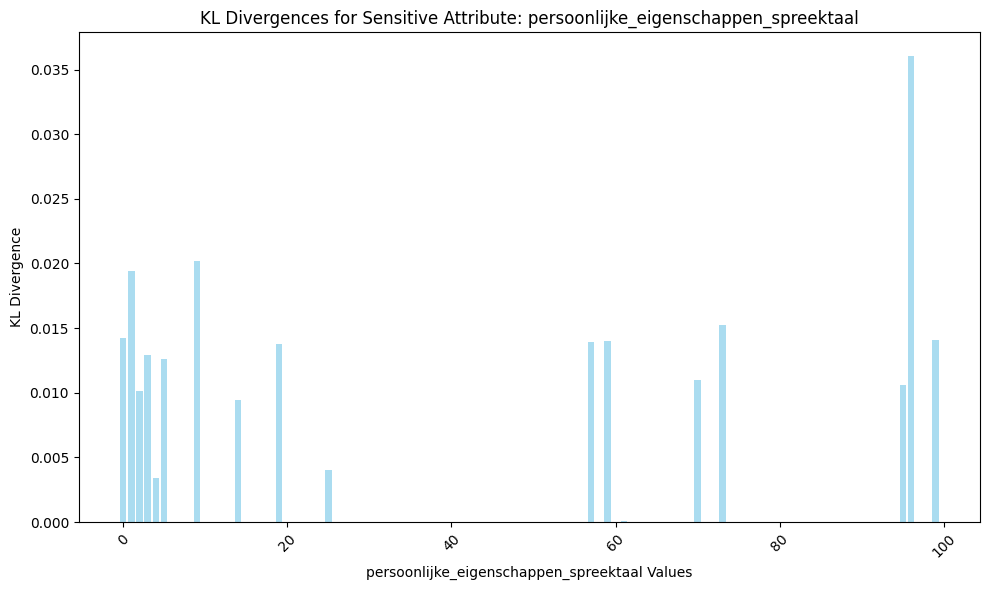

In [7]:
# visualize results

visualize_kl_divergences(results)
